# 強化学習

[参考サイト](https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html#)

以下は、PyTorch公式DQNチュートリアルのコードの流れを、数式を用いてさらに詳しく説明したものです。

1. ライブラリと環境の準備
- 環境の設定
OpenAI GymのCartPole-v1環境を作成します。この環境は以下の状態変数（state）を持ちます：  
$s = (\text{cart position}, \text{cart velocity}, \text{pole angle}, \text{pole angular velocity})$

￼
行動（action）は2つ：
- 0: 左に動かす。
- 1: 右に動かす。
- デバイスの設定
GPUが利用可能ならcudaを、そうでなければCPUを使用します：  

$
\text{device} =
\begin{cases}
\text{cuda}, & \text{if GPU is available} \\
\text{cpu}, & \text{otherwise}
\end{cases}
$
￼

2. 経験リプレイ（Replay Memory）
- リプレイメモリには、以下のタプルを保存します：  
$(s_t, a_t, r_t, s_{t+1}, \text{done})$

￼
ここで：
-  $s_t$ ￼: 現在の状態。
-  $a_t$￼: 現在の行動。
- ￼$r_t$ : 報酬。
-  $s_{t+1}$ ￼: 次の状態。
- $\text{done}$￼: エピソードが終了したかどうか。
- リプレイメモリの目的
強化学習のデータは連続して生成されるため、学習がバイアスされる可能性があります。リプレイメモリを使用することで、データをランダムにサンプリングし、学習を安定させます。

1. ニューラルネットワークの定義
- Q-Network
状態 $s$ を入力とし、各行動 $a$ のQ値を出力するネットワーク：
￼
ここで、$\theta$￼ はネットワークのパラメータ。
- ネットワークのアーキテクチャ
- 入力層：状態 ￼$s$ の次元数（4次元）。
- 隠れ層：線形層（128ユニット）。
- 出力層：行動数（2次元）。

1. ハイパーパラメータの設定

以下のパラメータを設定します：
- ￼$\alpha$（学習率）：ネットワーク更新の速さ。
- ￼$\gamma$（割引率）：将来の報酬の重要性を調整。
- ￼$\epsilon$（探索率）：ランダム行動の確率。
- バッチサイズ：リプレイメモリからサンプリングするデータ数。
- リプレイメモリの最大サイズ。

5. 行動ポリシー（ε-greedyポリシー）
- ポリシー
現在の状態 $s_t$ に基づき、行動 $a_t$ を次のように選択：  

$
a_t =
\begin{cases}
\text{random action}, & \text{with probability } \epsilon \\
\arg\max_a Q(s_t, a; \theta), & \text{otherwise}
\end{cases}
$
￼
- 探索と活用のバランス
￼ $\epsilon$ を徐々に減らすことで、初期段階では探索を重視し、学習が進むにつれて活用を重視します。

6. 学習の流れ

1. 状態と行動の収集
- 環境をリセットして初期状態 $s_0$ を取得。
- 行動 $a_t$ を選択し、環境に適用。

2. 環境からの応答
- 次の状態 $s_{t+1}$￼、報酬 $r_t$￼、終了フラグ $\text{done}$ を取得。
- リプレイメモリにタプル $(s_t, a_t, r_t, s_{t+1}, \text{done})$￼ を保存。

3. Q値の更新

リプレイメモリからランダムにバッチをサンプリングし、以下を計算：
	1.	ターゲットQ値
ターゲットネットワークを用いて次のように計算：

$
y = r_t + \gamma \max_{a{\prime}} Q(s_{t+1}, a{\prime}; \theta^-)
$
￼
ここで、$\theta^-$￼ はターゲットネットワークのパラメータ。
	2.	損失関数
現在のQ値とターゲットQ値の差をMSEで評価：

$
\text{Loss} = \frac{1}{N} \sum_{i=1}^N \left( y_i - Q(s_i, a_i; \theta) \right)^2
$
￼
	3.	パラメータ更新
オプティマイザを用いてネットワークのパラメータ $\theta$ を更新。

7. ターゲットネットワークの更新

一定の間隔でターゲットネットワークをポリシーネットワークと同期：

$
\theta^- \gets \theta
$
￼

8. 学習の終了条件

以下のいずれかでエピソードを終了：
- ポールが倒れる（環境の終了条件）。
- エージェントが200ステップ以上バランスを維持。

9. 可視化と結果の保存
- 各エピソードの報酬を記録し、学習の進捗を可視化。
- 最終的なモデルを保存してエージェントの性能を評価。

この流れに基づいて、DQNアルゴリズムはポールのバランスを取るタスクを学習し、成功率を高めていきます。必要に応じてさらなる詳細を説明できます！

In [1]:
!pip install gymnasium


[notice] A new release of pip is available: 24.1.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [3]:
import gymnasium as gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

env = gym.make("CartPole-v1")

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if GPU is to be used
device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu"
)

このコードは、強化学習環境でよく使われるCartPole-v1（棒付きカート）の環境をセットアップし、PyTorchを使った強化学習の準備をするものです。以下に詳しく解説します：

1. インポート部分
- gymnasium: 強化学習環境を提供するライブラリ（CartPole-v1環境もここから）。
- matplotlib: グラフやデータ可視化用ライブラリ。
- torchおよび関連モジュール: ニューラルネットワークの構築、学習アルゴリズムの実装に使用。
- その他のモジュール: データ構造やループ処理に便利なツール。

2. 環境のセットアップ

```python
env = gym.make("CartPole-v1")
```

- CartPole-v1環境を作成します。この環境は、倒立振子問題と呼ばれるもので、カートを左右に動かして棒が倒れないようにバランスを取るタスクです。
- この環境を使用して、強化学習エージェントの訓練を行います。

3. Matplotlibの設定

```python
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display
plt.ion()
```

- is_ipython: 実行環境がJupyter Notebookのようなインタラクティブ環境かを判定。
- plt.ion(): Matplotlibをインタラクティブモードで動作させ、リアルタイムのプロットを可能にする設定。

4. デバイスの選択

```python
device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu"
)
```

- 使用するデバイスを自動判定します。
- GPU（cuda）: 高速な計算に利用。
- MPS（Metal Performance Shaders）: macOSでGPU計算を可能にするAppleの技術。
- CPU: 上記が利用できない場合のデフォルト。

## リプレイメモリ

In [4]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

**ReplayMemory クラスの説明**

`ReplayMemory` クラスは、強化学習のエージェントが経験を記録し、学習のためにランダムにサンプルを抽出するためのメモリバッファを提供します。このクラスは、経験再生 (Experience Replay) の実装に使用されます。経験再生は、過去の遷移（状態、行動、報酬、次の状態）を保存し、それらをランダムにサンプリングして学習に使用することで、学習の効率を向上させます。

**クラス定義**

```python
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))
```

- Transitionは、エージェントの状態、行動、次の状態、報酬を保持するタプルを定義します。
- これにより、経験の各要素にアクセスしやすくなります。
- 主要概要(例えば犬と飼い主の例)
  - エージェント(agent):行動を行う主体→犬
  - 行動(action):環境に対して行う働きかけの種類→おすわり、お手など。犬は座る行動を取る。
  - 環境(environment):エージェントが働きかけを行う対象→飼い主の指示や家の中、公園などの環境全体
  - 方策(policy):行動を決める規則→犬は「お座り」の命令を聞いたら座るべきだと判断する。
  - 状態(state):エージェントが行動すると次の状態に遷移する→犬が座った状態になり、次の指示を待つ。
  - 報酬(reward):ある状態の良さを評価するための信号→飼い主がおやつをあげる（ポジティブな報酬）。
  - エピソード(episode):一連の行動のまとまり→公園で散歩する間、犬が一連の行動をすること

**ReplayMemory クラス**

```python
class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)
```

- __init__(self, capacity):
- capacityはメモリの最大容量を設定します。
- メモリはdeque（双方向キュー）で実装されており、maxlen=capacityによりメモリのサイズを制限します。これにより、容量を超えると古い経験が自動的に削除されます。

```python
def push(self, *args):
    """Save a transition"""
    self.memory.append(Transition(*args))
```

- push(self, *args):
- 経験（状態、行動、次の状態、報酬）を引数として受け取り、それをTransitionタプルにラップしてmemoryに追加します。
- *argsにより、必要な引数を展開してTransitionに渡します。

```python
def sample(self, batch_size):
    return random.sample(self.memory, batch_size)
```

- sample(self, batch_size):
- batch_sizeに指定された数だけランダムに経験をサンプリングし、そのサンプルを返します。
- サンプリングは、リプレイメモリからランダムに行われるため、エージェントが特定の経路に偏らず、より一般的な学習を行えるようになります。

```python
def __len__(self):
    return len(self.memory)
```

- __len__(self):
- 現在メモリに保存されている経験の数を返します。len(replay_memory)のように使うことができます。

ReplayMemory クラスの使用例

以下のコードは、ReplayMemoryクラスの使用例です。

**メモリの初期化**
memory = ReplayMemory(capacity=10000)

**経験をメモリに保存**  
state = [1.0, 0.0]  # 仮の状態  
action = 1           # 仮の行動  
next_state = [0.5, 0.5]  # 仮の次の状態  
reward = 1           # 仮の報酬  

memory.push(state, action, next_state, reward)

**メモリからサンプルを取得**
batch = memory.sample(32)

**サンプルの内容を表示**
for transition in batch:
    print(transition)

**経験再生の利点**

1.	相関性の低減:
- 連続した経験が相関していると学習が難しくなるため、ランダムにサンプルを抽出することで、この相関性を減らすことができます。
2.	効率的な学習:
- 過去の経験を再利用することで、より効率的に学習が行われます。これにより、環境とのインタラクションを最小限に抑えつつ、より多くの学習を行うことができます。
3.	探索と活用のバランス:
- サンプリングされた経験がランダムであるため、エージェントは探索と活用のバランスを取ることができ、局所最適解に陥ることを防ぎます。

**結論**

ReplayMemoryクラスは、強化学習における重要なコンポーネントであり、過去の経験を保存し、それをランダムにサンプリングすることで、エージェントの学習を効率的に進める役割を果たします。このクラスを活用することで、学習の安定性や効率が向上します。



## DQNアルゴリズム

### Qネットワーク

In [5]:
import torchsummary
from torchsummary import summary

class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)
    
summary(DQN(env.observation_space.shape[0], env.action_space.n), (env.observation_space.shape[0],))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]             640
            Linear-2                  [-1, 128]          16,512
            Linear-3                    [-1, 2]             258
Total params: 17,410
Trainable params: 17,410
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.07
Estimated Total Size (MB): 0.07
----------------------------------------------------------------


このコードはニューラルネットワークのモデル構造を表示するもので、output shape と param は、各層（Layer）の出力形状とパラメータ数を表しています。以下で詳しく説明します。

1. Output Shape（出力形状）

output shape は、各層が出力するテンソル（多次元配列）の形状を表します。
具体的には、以下を意味します：
- [-1, 128]
- -1: ミニバッチサイズ（入力データの個数）。この値は実際のデータに依存するため、固定されず「動的サイズ」として -1 で表されます。
- 128: 層が出力する特徴量の数。

2. Param（パラメータ数）

param は、その層が持つ学習可能なパラメータ（重みとバイアス）の総数を表します。

例: Linear 層の場合
- 線形層（全結合層）は以下の式でパラメータ数が計算されます：
￼

Linear-1
- 入力ユニット数 = 4￼（暗黙的に入力次元として仮定）
- 出力ユニット数 = ￼128
- パラメータ数 = ￼128*4+128=640

Linear-2
- 入力ユニット数 = ￼128
- 出力ユニット数 = ￼128
- パラメータ数 = ￼16384+128=16512

Linear-3
- 入力ユニット数 = ￼128
- 出力ユニット数 = ￼2
- パラメータ数 = ￼128*2+2

3. その他の情報

Total params
- モデル全体のパラメータ数の合計（ここでは 17410￼）。

Trainable params
- 学習可能なパラメータ数（ここではすべて学習可能なので 17410￼）。

Non-trainable params
- 学習されない固定パラメータ数（ここでは 0￼）。

全体の流れの解釈
- 入力（例えば、次元 4￼ のデータ）が最初の層 Linear-1 を通り、出力形状が ￼[-1, 128] になります。
- その出力が次の層 Linear-2 に入力され、再び出力形状が ￼[-1, 128] となります。
- 最後に Linear-3 に渡され、出力が ￼[-1, 2] となり、これは最終的な予測結果（クラス分類ならクラス数、回帰なら2次元の出力）を表します。

## トレーニング

### ハイパーパラメータとユーティリティ

In [6]:
# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the ``AdamW`` optimizer
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4

# Get number of actions from gym action space
n_actions = env.action_space.n
# Get the number of state observations
state, info = env.reset()
n_observations = len(state)

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)


steps_done = 0


def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1).indices.view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)


episode_durations = []


def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

このコードは、強化学習の一種である **DQN（Deep Q-Network）** を使ったエージェントの学習を行うためのものです。DQNは、Q学習という手法をディープラーニングで実装したもので、状態と行動に基づいて価値（Q値）を学習し、最適な行動を選択する方法です。

コードの主要な部分について、順を追って説明します。

1. 設定パラメータ

- BATCH_SIZE: バッチサイズ。リプレイメモリからサンプルする遷移の数です。
- GAMMA: 割引率。未来の報酬の価値をどれだけ重視するかを決めます（0.99はほぼ未来の報酬を重視）。
- EPS_START: ε-greedy法の最初のεの値。エージェントがランダムに行動する確率です。
- EPS_END: ε-greedy法の最終的なεの値。エージェントがランダムに行動する確率の最小値です。
- EPS_DECAY: εの減衰率。エージェントがランダムに行動する確率がどのくらいの速度で減少するかを決めます。
- TAU: ターゲットネットワークの重みの更新率。ターゲットネットワークをポリシーネットワークの重みで少しずつ更新します。
- LR: AdamWオプティマイザの学習率です。

2. 環境とネットワークの設定

- n_actions: 環境から可能な行動数を取得しています。
- state: 環境の初期状態を取得します。
- n_observations: 環境の状態空間の次元数を取得します。

その後、DQN（policy_net と target_net）というニューラルネットワークを作成しています。ポリシーネットワークとターゲットネットワークは最初は同じ重みを持ち、ターゲットネットワークは学習過程でポリシーネットワークに基づいて更新されます。

3. オプティマイザとメモリの準備

- optimizer: ポリシーネットワークのパラメータを最適化するために、AdamWオプティマイザが設定されています。
- memory: 遷移を保存するためのリプレイメモリ（ReplayMemoryクラス）を作成します。これにより、過去の経験を再利用して学習します。

4. select_action関数

この関数は、エージェントがどの行動を選択するかを決定します。
- ε-greedy法を使用して行動を選びます。sampleというランダム値を生成し、それがεより大きければポリシーネットワークの出力に基づいて最適な行動を選択します（policy_net(state).max(1).indices）。
- それ以外の場合は、ランダムな行動を選びます（env.action_space.sample()）。

この方法により、エージェントは最初はランダムに行動し、学習が進むにつれて最適な行動を選ぶ確率が高くなります。

5. plot_durations関数

この関数は、エージェントの学習過程を可視化するためのものです。
- 各エピソードの完了にかかった時間（episode_durations）をプロットし、学習の進行状況を視覚的に表示します。
- エピソード数が100回以上になると、過去100エピソードの平均をプロットします。これにより、学習が進むにつれてエージェントがどのように改善していくかを確認できます。

**まとめ**

このコードは、Deep Q-Network (DQN) を用いて、強化学習を行うエージェントの設定と学習の進行管理を行っています。エージェントはランダムに行動しながら、報酬を受け取ってQ値を更新し、最適な行動を選ぶように学習します。進行状況はグラフで表示され、エージェントがどれだけうまく学習しているかを確認できます。

### トレーニングループ

In [7]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1).values
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

このコードは、強化学習におけるQ学習の更新手順を行う関数optimize_modelです。具体的には、**Deep Q-Network (DQN)**を使ったポリシーネットワークのパラメータを最適化する処理を実行しています。以下に、コードの各部分を詳しく説明します。

1. リプレイメモリのサンプル処理

```python
if len(memory) < BATCH_SIZE:
    return
transitions = memory.sample(BATCH_SIZE)
```

- memory（リプレイメモリ）から、指定されたBATCH_SIZE（128）の数だけ遷移（状態、行動、報酬、次の状態）をサンプリングします。
- もしメモリのサイズがBATCH_SIZEより小さい場合、最適化は行いません。

2. サンプルされた遷移を転置してバッチ化

```python
batch = Transition(*zip(*transitions))
```

- サンプリングされた遷移（transitions）を、各要素（状態、行動、次の状態、報酬）ごとに分解して、Transitionというタプルにまとめます。
- zip(*transitions)は、リストを転置する操作で、遷移の各要素を個別に扱いやすくするために使用されます。

3. 最終状態のマスク処理

```python
non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
```

- batch.next_state（次の状態）がNoneでないものを「非最終状態」としてマスクします。
- これによって、エージェントが終了した（最終状態）場合、次の状態の価値を計算しないようにします。

4. 状態とアクションのバッチ化

```python
non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
state_batch = torch.cat(batch.state)
action_batch = torch.cat(batch.action)
reward_batch = torch.cat(batch.reward)
```

- next_stateがNoneでないものだけをnon_final_next_statesとしてまとめます。
- それぞれの状態（state_batch）、行動（action_batch）、報酬（reward_batch）をバッチ化します。

5. 現在の状態のQ値計算

```python
state_action_values = policy_net(state_batch).gather(1, action_batch)
```

- policy_net(state_batch)は現在の状態バッチに対して、各アクションに対するQ値を計算します。
- .gather(1, action_batch)は、バッチ内で実際に選択した行動に対応するQ値を抽出します。
- これにより、実際に行動したときのQ値（state_action_values）を得ます。

6. 次の状態のQ値計算

```python
next_state_values = torch.zeros(BATCH_SIZE, device=device)
with torch.no_grad():
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
```

- next_state_valuesは、次の状態に対する期待されるQ値を格納するテンソルです。
- non_final_maskに基づいて、target_net（ターゲットネットワーク）を使って非最終状態に対する最大Q値を計算します（max(1).values）。
- 最終状態の場合は、次の状態のQ値は0になります。

7. 期待されるQ値の計算

```python
expected_state_action_values = (next_state_values * GAMMA) + reward_batch
```

- GAMMAは割引率で、次の状態から得られるQ値を現在のQ値に引き継ぎます。
- 次の状態から得られるQ値に割引率を掛けた値と、現在の報酬（reward_batch）を加算して、期待されるQ値（expected_state_action_values）を計算します。

8. 損失関数の計算（Huber Loss）

```python
criterion = nn.SmoothL1Loss()
loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))
```

- 損失関数として、Huber Loss（SmoothL1Loss）を使用します。これは、Q値の予測と期待されるQ値の間の誤差を計算します。
- expected_state_action_values.unsqueeze(1)で、期待されるQ値をバッチに合わせた形に整形します。

9. 最適化の実行

```python
optimizer.zero_grad()
loss.backward()
torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
optimizer.step()
```

- optimizer.zero_grad()で、前回の勾配をリセットします。
- loss.backward()で、損失関数に基づいてネットワークのパラメータに対する勾配を計算します。
- torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)で、勾配の値をクリッピング（最大値100に制限）して、勾配爆発を防ぎます。
- optimizer.step()で、計算された勾配に基づいてポリシーネットワークのパラメータを更新します。

**まとめ**

この関数は、強化学習のDQNアルゴリズムにおけるQ値の更新を行っています。リプレイメモリからサンプルされた遷移を使って、次の状態のQ値を計算し、期待されるQ値と現在のQ値の差を最小化するようにポリシーネットワークを最適化しています。この最適化によって、エージェントはより良い行動選択ができるように学習します。

Complete


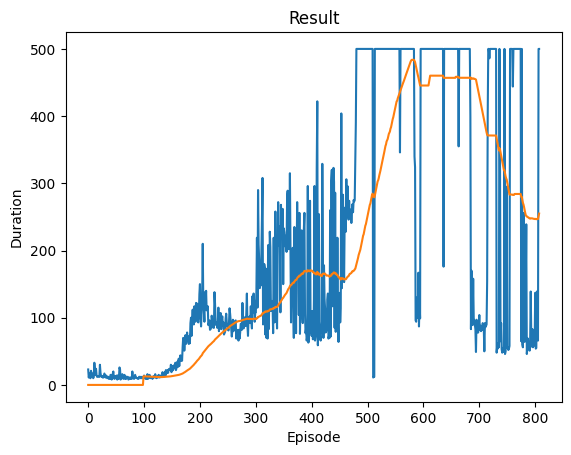

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [10]:
if torch.cuda.is_available() or torch.backends.mps.is_available():
    num_episodes = 600
else:
    num_episodes = 50

for i_episode in range(num_episodes):
    # Initialize the environment and get its state
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    for t in count():
        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break

print('Complete')
plot_durations(show_result=True)
plt.ioff()
plt.show()

グラフの読み方
1.	横軸（x-axis）：エピソードの回数
- 1回目のゲーム、2回目のゲーム……というように、エピソード（ゲーム）の番号を表します。
2.	縦軸（y-axis）：ゲームの長さ
- 1回のゲームで棒が倒れるまでの時間をステップ数（回数）で表します。
- 値が高いほど、棒を長く倒さずにキープできたことを意味します。

In [13]:
state, info = env.reset()
print(state)
print(info)
i = env.action_space.sample()
print(i)
state, reward, done, info, _ = env.step(i)
print(state, reward, done, info)

[-0.02918209 -0.02873599  0.00890046  0.03575325]
{}
0
[-0.02975681 -0.22398444  0.00961553  0.33123103] 1.0 False False


In [9]:
'''
from tqdm.notebook import tqdm
from itertools import count

# GPUまたはMPSが使用可能な場合、エピソード数を設定
if torch.cuda.is_available() or torch.backends.mps.is_available():
    num_episodes = 600
else:
    num_episodes = 50

# tqdmを使用して進行状況バーを表示
for i_episode in tqdm(range(num_episodes), desc="Episodes", leave=True, unit="episode"):
    # 環境を初期化し、状態を取得
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    for t in count():
        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # メモリに遷移を保存
        memory.push(state, action, next_state, reward)

        # 次の状態に移動
        state = next_state

        # ポリシーネットワークの最適化
        optimize_model()

        # ターゲットネットワークの重みのソフトアップデート
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break

    # tqdmの進行状況バーを更新
    tqdm.write(f"Episode {i_episode+1} complete")

print('Complete')
plot_durations(show_result=True)
plt.ioff()
plt.show()
'''

'\nfrom tqdm.notebook import tqdm\nfrom itertools import count\n\n# GPUまたはMPSが使用可能な場合、エピソード数を設定\nif torch.cuda.is_available() or torch.backends.mps.is_available():\n    num_episodes = 600\nelse:\n    num_episodes = 50\n\n# tqdmを使用して進行状況バーを表示\nfor i_episode in tqdm(range(num_episodes), desc="Episodes", leave=True, unit="episode"):\n    # 環境を初期化し、状態を取得\n    state, info = env.reset()\n    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)\n    for t in count():\n        action = select_action(state)\n        observation, reward, terminated, truncated, _ = env.step(action.item())\n        reward = torch.tensor([reward], device=device)\n        done = terminated or truncated\n\n        if terminated:\n            next_state = None\n        else:\n            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)\n\n        # メモリに遷移を保存\n        memory.push(state, action, next_state, reward)\n\n        # 次の状態に移動\n        state = next_

このコードは、強化学習におけるエピソードの繰り返し実行部分で、主に**DQN (Deep Q-Network)**アルゴリズムに基づいています。以下に、コードの各部分を細かく説明します。

1. デバイス設定とエピソード数の決定

```python
if torch.cuda.is_available() or torch.backends.mps.is_available():
    num_episodes = 600
else:
    num_episodes = 50
```

- この部分では、使用可能なハードウェア（GPUやMPS（Metal Performance Shaders））がある場合、num_episodes（エピソード数）を600に設定します。ハードウェアがない場合は、エピソード数を50に設定します。
- これにより、ハードウェアの性能に応じて学習の規模を変えています。

2. エピソードごとの繰り返し処理

```python
for i_episode in range(num_episodes):
    # Initialize the environment and get its state
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
```

- ここで、num_episodes回だけループします。
- 各エピソードの開始時に、env.reset()を呼び出して環境をリセットし、初期状態（state）を取得します。
- 取得した状態をtorch.tensorに変換して、PyTorchのテンソル形式にします（dtype=torch.float32、device=deviceで指定されたデバイスに転送）。
- unsqueeze(0)は、状態が1次元テンソルでなく、バッチ処理に対応できるようにバッチ次元を追加します。

3. タイムステップごとの処理

```python
for t in count():
    action = select_action(state)
    observation, reward, terminated, truncated, _ = env.step(action.item())
    reward = torch.tensor([reward], device=device)
    done = terminated or truncated
```

- count()を使って、各エピソードでタイムステップを順に処理します。
- select_action(state)を呼び出して、現在の状態に対するアクションを選択します。
- 環境に対して、選択したアクションを実行（env.step(action.item())）し、その結果をobservation（次の状態）、reward（報酬）、terminated（終了フラグ）、truncated（途中終了フラグ）として受け取ります。
- rewardをPyTorchテンソルに変換し、デバイスに転送します（device=device）。
- doneフラグは、terminatedかtruncatedがTrueならエピソードが終了したことを示します。

4. 次の状態の処理

```python
if terminated:
    next_state = None
else:
    next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)
```

- terminated（エピソード終了フラグ）がTrueの場合、次の状態はNoneに設定します。
- そうでない場合、次の状態（observation）をPyTorchのテンソルに変換し、デバイスに転送してバッチ処理ができるようにします。

5. 遷移の記録

```python
memory.push(state, action, next_state, reward)
```

- 現在の状態、選択したアクション、次の状態、報酬をリプレイメモリ（memory）に保存します。この保存された遷移は後でDQNの更新に使用されます。

6. 状態の更新

```python
state = next_state
```

- 状態を次の状態に更新します。次の状態がNoneの場合、次のエピソードに進むことになります。

7. ポリシーネットワークの最適化

```python
optimize_model()
```

- optimize_model()関数を呼び出して、ポリシーネットワーク（policy_net）の最適化を行います。これは、DQNアルゴリズムにおけるQ値の更新を行う部分です。

8. ターゲットネットワークのソフト更新

```python
target_net_state_dict = target_net.state_dict()
policy_net_state_dict = policy_net.state_dict()
for key in policy_net_state_dict:
    target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
target_net.load_state_dict(target_net_state_dict)
```

- ターゲットネットワーク（target_net）のパラメータをソフトに更新します。
- TAUはソフト更新の割合を指定しており、ポリシーネットワークのパラメータをターゲットネットワークに少しずつ反映させます。これにより、ターゲットネットワークの急激な変動を避けることができます。
- target_net_state_dictにはターゲットネットワークの現在のパラメータが格納され、policy_net_state_dictにはポリシーネットワークのパラメータが格納されます。
- ソフト更新により、ターゲットネットワークのパラメータがポリシーネットワークのパラメータに基づいて更新されます。

9. エピソードの終了処理

```python
if done:
    episode_durations.append(t + 1)
    plot_durations()
    break
```

- doneフラグがTrueの場合、エピソードが終了したことを意味します。
- エピソードの終了時に、エピソードの長さ（t + 1）をepisode_durationsに追加し、plot_durations()でエピソードの進行状況を可視化します。
- その後、breakで内側のループを終了し、次のエピソードに進みます。

10. 学習の終了後に結果を表示

```python
print('Complete')
plot_durations(show_result=True)
plt.ioff()
plt.show()
```

- すべてのエピソードが完了した後に、「Complete」と表示し、学習結果をプロットします。
- plt.ioff()でインタラクティブモードをオフにし、plt.show()で最終的なグラフを表示します。

**まとめ**

このコードは、強化学習におけるDQNアルゴリズムの学習部分で、複数のエピソードにわたって環境の状態遷移を利用してポリシーネットワークを学習します。具体的には、各エピソードで環境とやり取りし、その結果をリプレイメモリに保存、ポリシーネットワークを最適化し、ターゲットネットワークをソフトに更新する処理を行っています。最終的に、エピソードごとの進行状況を可視化しています。